<a target="_blank" href="https://colab.research.google.com/github/modelica/fmi-beginners-tutorial-2025/blob/main/part3/tutorial_multiple_FMUs/interaction_with_multiple_fmus.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Running Co-simulations with the INTO-CPS Maestro Co-simulation Engine

The goal of this notebook is to highlight how to run a co-simulation using an open source tool.

It is meant to represent one of the simplest ways to get started running co-simulations with a command line tool.

The notebook is organized into two parts:
1. The first part is focused on running a co-simulation from the command line without concern for the accuracy of the results.
2. The second part shows how the accuracy of the co-simulation can be measured provided that there exists a baseline reference.

Running a co-simulation using the INTO-CPS co-simulation orchestration requires the user to specify the co-simulation scenario in a JSON file, which is then fed into the tool which will load the FMUS and produce the results as a CSV file.

In [2]:
# Import all dependencies
import json
import subprocess
import pandas
import matplotlib.pyplot as plt
import numpy as np
import time


In [3]:
%%bash
git clone https://github.com/modelica/fmi-beginners-tutorial-2025.git

Cloning into 'fmi-beginners-tutorial-2025'...


In [4]:
# Small details: make the jar executable in your platform.
%cd fmi-beginners-tutorial-2025/part3/tutorial_multiple_FMUs
coe_jar = "maestro.jar"


# Make jar executable.
command = f"chmod +x {coe_jar}"
result = subprocess.run(command, shell=True, capture_output=True, text=True)
if result.returncode != 0:
    raise RuntimeError(f"Error running command {command}: {result.stderr}")


/content/fmi-beginners-tutorial-2025/part3/tutorial_multiple_FMUs


## Part 1: Running Co-simulations from the Command Line

This part is divided into 2 sections:
1. Running a co-simulation of a single FMU.
2. Running a co-simulation with multiple interconnected FMUs.

### Running Co-simulations with Single FMU

In [5]:
# Prepare the co-simulation scenario description, which points to where the FMU.
singlefmu_scenario_json_file = "single_fmu_scenario.json"

# The following is a small detail whereby we need to find the absolute path of the FMU that is compatible with the platform of the user.
platform_folder = 'Linux'
# We can now see the co-simulation scenario as a json file:
with open(singlefmu_scenario_json_file, 'r') as file :
    scenario_raw = file.read()

print(json.dumps(json.loads(scenario_raw), indent=2))

{
  "fmus": {
    "{baseline}": "./fmus/MODELICA_Demo.ControlledElectricDrive.fmu"
  },
  "connections": {},
  "parameters": {},
  "logVariables": {
    "{baseline}.baselineInstance": [
      "w"
    ]
  },
  "algorithm": {
    "type": "fixed-step",
    "size": 0.001
  },
  "loggingOn": false,
  "overrideLogLevel": "INFO"
}


In [8]:
# Now we can run the co-simulation
coe_command = f"java -jar {coe_jar} --oneshot --configuration {singlefmu_scenario_json_file} --starttime 0 --endtime 1 -v"
result = subprocess.run(coe_command, shell=True, capture_output=True, text=True)

# Check the command's output
if result.returncode == 0:
    print(result.stdout)
else:
    raise RuntimeError(f"Error running command {coe_command}: {result.stderr}")

RuntimeError: Error running command java -jar maestro.jar --oneshot --configuration single_fmu_scenario.json --starttime 0 --endtime 1 -v: Error 0000: Array initializer must not be empty: {  } null
java.lang.RuntimeException: Expansion not possible type errors: Error 0000: Array initializer must not be empty: {  } null

	at org.intocps.maestro.MablSpecificationGenerator.expandExternals(MablSpecificationGenerator.java:140)
	at org.intocps.maestro.MablSpecificationGenerator.expandExternals(MablSpecificationGenerator.java:114)
	at org.intocps.maestro.MablSpecificationGenerator.generateFromDocuments(MablSpecificationGenerator.java:401)
	at org.intocps.maestro.Mabl.expand(Mabl.java:279)
	at org.intocps.maestro.webapi.maestro2.Maestro2Broker.postGenerate(Maestro2Broker.java:220)
	at org.intocps.maestro.webapi.maestro2.Maestro2Broker.generateSpecification(Maestro2Broker.java:216)
	at org.intocps.maestro.webapi.maestro2.Maestro2Broker.buildAndRun(Maestro2Broker.java:184)
	at org.intocps.maestro.webapi.Application$MableV1ToV2ProxyRunner.run(Application.java:83)
	at org.intocps.maestro.MaestroV1CliProxy.process(MaestroV1CliProxy.java:154)
	at org.intocps.maestro.webapi.Application.main(Application.java:43)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.springframework.boot.loader.MainMethodRunner.run(MainMethodRunner.java:48)
	at org.springframework.boot.loader.Launcher.launch(Launcher.java:87)
	at org.springframework.boot.loader.Launcher.launch(Launcher.java:51)
	at org.springframework.boot.loader.JarLauncher.main(JarLauncher.java:52)


In [ ]:
# We can see the results stored in "output.csv"
data = pandas.read_csv("output.csv")
data

In [ ]:
# As can can plot those results as follows
plt.figure()
plt.plot(data["time"], data["{baseline}.baselineInstance.w"], label="{baseline}.w")
plt.legend()
plt.show()

### Running a Co-simulation with Multiple FMUs

In [9]:
# Prepare the co-simulation scenario description, which points to where the FMUs are.

decoupled_scenario_json_file = "decoupled_scenario.json"

# We can now see the co-simulation scenario as a json file:
with open(decoupled_scenario_json_file, 'r') as file :
    scenario_raw = file.read()

print(json.dumps(json.loads(scenario_raw), indent=2))

{
  "fmus": {
    "{stimuli}": "./fmus/Stimuli.fmu",
    "{control}": "./fmus/Control.fmu",
    "{drive}": "./fmus/Drive.fmu"
  },
  "connections": {
    "{stimuli}.stimuliInstance.w_desired": [
      "{control}.controlInstance.w_desired"
    ],
    "{stimuli}.stimuliInstance.LoadTorque_Nm": [
      "{drive}.driveInstance.LoadTorque_Nm"
    ],
    "{control}.controlInstance.V": [
      "{drive}.driveInstance.V"
    ],
    "{drive}.driveInstance.w": [
      "{control}.controlInstance.w"
    ]
  },
  "parameters": {},
  "algorithm": {
    "type": "fixed-step",
    "size": 0.001
  },
  "loggingOn": false,
  "overrideLogLevel": "INFO"
}


In [10]:
# Now we can run the co-simulation
coe_command = f"java -jar {coe_jar} --oneshot --configuration {decoupled_scenario_json_file} --starttime 0 --endtime 1 --result output.csv"
result = subprocess.run(coe_command, shell=True, capture_output=True, text=True)

# Check the command's output
if result.returncode == 0:
    print(result.stdout)
else:
    raise RuntimeError(f"Error running command {coe_command}: {result.stderr}")

Version: 2.1.9
Interpretation load took: 561772248
Interpretation load took: 349389418
Interpretation load took: 248977585
Interpretation instantiate took: 102207750
Interpretation instantiate took: 33540110
Interpretation instantiate took: 48428500
Interpretation time: 5457872381 PT5.457766S



In [11]:
# If all went well, we can see the results stored in "output.csv"
data = pandas.read_csv("output.csv")
data

,time,{stimuli}.stimuliInstance.w_desired,{stimuli}.stimuliInstance.LoadTorque_Nm,{control}.controlInstance.V,{drive}.driveInstance.w
0,0.000,0.0,0.0,0.000000,0.000000
1,0.001,0.0,0.0,0.000000,0.000000
2,0.002,0.0,0.0,0.000000,0.000000
3,0.003,0.0,0.0,0.000000,0.000000
4,0.004,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...
995,0.995,10.0,3.0,5.963236,10.000001
996,0.996,10.0,3.0,5.963236,10.000001
997,0.997,10.0,3.0,5.963236,10.000001
998,0.998,10.0,3.0,5.963236,10.000001


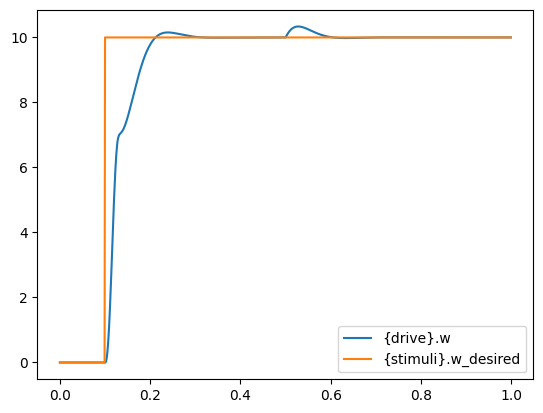

In [12]:
# As can can plot those results as follows
plt.figure()
plt.plot(data["time"], data["{drive}.driveInstance.w"], label="{drive}.w")
plt.plot(data["time"], data["{stimuli}.stimuliInstance.w_desired"], label="{stimuli}.w_desired")
plt.legend()
plt.show()

## Part 2: Measuring Accuracy of the Co-simulation Wrt to Baseline

In this part we show how to measure the accuracy of a co-simulation and the impact of the co-simulation step size in the accuracy.
We have two sections:
1. We run a co-simulation scenario where we include the baseline as an FMU that is run in parallel with the other fmus, that are representing the same system, but in a decoupled manner.
2. In the second section we run multiple experiments with different communication steps in order to highlight the impact of this parameter in the accuracy.

### Co-simulation Scenario with Baseline

In [13]:
# Prepare the co-simulation scenario description, which points to where the FMUs are.
baseline_scenario_json_template = "baseline_scenario_template.json"
baseline_scenario_json_file = "baseline_scenario.json"

# We can now see the co-simulation scenario as a json file:
with open(baseline_scenario_json_file, 'r') as file:
    scenario_raw = file.read()

print(json.dumps(json.loads(scenario_raw), indent=2))

{
  "fmus": {
    "{stimuli}": "./fmus/Stimuli.fmu",
    "{control}": "./fmus/Control.fmu",
    "{drive}": "./fmus/Drive.fmu",
    "{baseline}": "./fmus/MODELICA_Demo.ControlledElectricDrive.fmu"
  },
  "connections": {
    "{stimuli}.stimuliInstance.w_desired": [
      "{control}.controlInstance.w_desired"
    ],
    "{stimuli}.stimuliInstance.LoadTorque_Nm": [
      "{drive}.driveInstance.LoadTorque_Nm"
    ],
    "{control}.controlInstance.V": [
      "{drive}.driveInstance.V"
    ],
    "{drive}.driveInstance.w": [
      "{control}.controlInstance.w"
    ]
  },
  "parameters": {},
  "logVariables": {
    "{baseline}.baselineInstance": [
      "w"
    ]
  },
  "algorithm": {
    "type": "fixed-step",
    "size": 0.001
  },
  "loggingOn": false,
  "overrideLogLevel": "INFO"
}


In [14]:
# Now we can run the co-simulation
coe_command = f"java -jar {coe_jar} --oneshot --configuration  {baseline_scenario_json_file} --starttime 0 --endtime 1 --result output.csv"
result = subprocess.run(coe_command, shell=True, capture_output=True, text=True)

# Check the command's output
if result.returncode == 0:
    print(result.stdout)
else:
    raise RuntimeError(f"Error running command {coe_command}: {result.stderr}")

Version: 2.1.9
Interpretation load took: 318116850
Interpretation load took: 193497995
Interpretation load took: 238147735
Interpretation load took: 227771261
Interpretation instantiate took: 62238043
Interpretation instantiate took: 26908715
Interpretation instantiate took: 23512154
Interpretation time: 6801392625 PT6.801281S



In [16]:
# If all went well, we can see the results stored in "output.csv"
data = pandas.read_csv("output.csv")
data

,time,{stimuli}.stimuliInstance.w_desired,{stimuli}.stimuliInstance.LoadTorque_Nm,{control}.controlInstance.V,{drive}.driveInstance.w
0,0.000,0.0,0.0,0.000000,0.000000
1,0.001,0.0,0.0,0.000000,0.000000
2,0.002,0.0,0.0,0.000000,0.000000
3,0.003,0.0,0.0,0.000000,0.000000
4,0.004,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...
995,0.995,10.0,3.0,5.963236,10.000001
996,0.996,10.0,3.0,5.963236,10.000001
997,0.997,10.0,3.0,5.963236,10.000001
998,0.998,10.0,3.0,5.963236,10.000001


In [17]:
# And we can plot those results as follows

plt.figure()
plt.plot(data["time"], data["{baseline}.baselineInstance.w"], label="{baseline}.w")
plt.plot(data["time"], data["{drive}.driveInstance.w"], label="{drive}.w")
plt.plot(data["time"], data["{stimuli}.stimuliInstance.w_desired"], label="{stimuli}.w_desired")
plt.legend()
plt.show()

KeyError: '{baseline}.baselineInstance.w'

<Figure size 640x480 with 0 Axes>

In [ ]:
# Now we measure the error and print it:

def error(ref_series, approx_series):
    error_signal = ref_series.to_numpy() - approx_series.to_numpy()
    sum_squared_differences = np.sum(error_signal ** 2)
    return sum_squared_differences

error(data["{baseline}.baselineInstance.w"], data["{drive}.driveInstance.w"])

### Impact of Step Size in the Accuracy

This section is a bit more advanced.
What we want is to run many simulations with different step sizes, and for each of these runs, we want to collect the results, calculate their error and store it.
Then, we can create a plot that compares the different step sizes with the achieved error.

In [ ]:
# So we need a function to run a full experiment given a step size.
def searchAndReplace(key, value, fileSrc, fileTrg):
  '''
  Opens a file fileSrc and searches for all occurrences of key string and replaces it by value.
  Stores the result in fileTrg.
  '''
  with open(fileSrc, 'r') as file :
    filedata = file.read()

  filedata = filedata.replace(key, value)

  with open(fileTrg, 'w') as file:
    file.write(filedata)

def run_experiment_with_step_size(step_size):
  # Set the step size in the config file:
  searchAndReplace("0.001", str(step_size), baseline_scenario_json_template, baseline_scenario_json_file)

  start_time_seconds = time.time()
  result = subprocess.run(coe_command, shell=True, capture_output=True, text=True)
  elapsed_time_seconds = time.time() - start_time_seconds

  # Check for failure and print debug information
  if result.returncode != 0:
    with open(baseline_scenario_json_file, 'r') as file:
        scenario_raw = file.read()
    raise RuntimeError(f"Error running command {coe_command} for step size {step_size}: {result.stderr}. \nThe input scenario is:\n{json.dumps(json.loads(scenario_raw), indent=2)}")

  # Read results and compute error
  data = pandas.read_csv("output.csv")

  return error(data["{baseline}.baselineInstance.w"], data["{drive}.driveInstance.w"]), elapsed_time_seconds

# Define possible step sizes we wish to try.
step_sizes = np.linspace(0.0001, 0.001, 4)
print(f"step_sizes = {step_sizes}")

# Run an experiment for each step size. CAUTION: this takes time.
results = [run_experiment_with_step_size(step_size) for step_size in step_sizes]
errors = [r[0] for r in results]
execution_times = [r[1] for r in results]

print(f"errors = {errors}")
print(f"execution_times = {execution_times}")

In [ ]:
# Plot the results

fig, axs = plt.subplots(2, 1)

axs[0].plot(step_sizes, errors, label="Error")
axs[0].legend()

axs[1].plot(step_sizes, execution_times, label="Execution time")
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()